In [9]:
import pickle
import torch
import torch_geometric as tg

import networkx as nx

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [59]:
with open(r'inf_scores_GT.pkl', 'rb') as f:
    all_res = pickle.load(f)
    print(f"{len(all_res)} graphs loaded")

x = all_res[0]

64 graphs loaded


In [60]:
# Normalisation code

inf = x['influence_score'].copy()

def row_normalise(inf):

    row_totals = inf.sum(axis=1)
    norm = (inf.T/row_totals).T

    return norm

assert np.allclose(row_normalise(inf).sum(axis=1), 1.0)

In [75]:
inf = row_normalise(inf)
df = pd.DataFrame(inf)

In [76]:
df.index.name = 'source' # TODO is this right?

melted = df.melt(ignore_index = False)
melted = melted.reset_index() # Move source index to be a column, gives unique index
melted = melted.rename(columns={'variable': 'target',
                                'value': 'influence_score',
                                'index': 'source'})

In [77]:
source_coords = pd.DataFrame(x['xpos'])
target_coords = source_coords.copy()

source_coords.index.name = 'source'
source_coords = source_coords.reset_index()

target_coords.index.name = 'target'
target_coords = target_coords.reset_index()


target_cords = target_coords.rename(columns={0: 'target_x', 1: 'target_y'})
source_coords = source_coords.rename(columns={0: 'source_x', 1: 'source_y'})

In [78]:
print(len(melted))

238144


In [79]:
melted = melted.merge(source_coords, on='source', how='left')
melted = melted.merge(target_cords, on='target', how='left')

In [80]:
print(len(melted))

238144


In [81]:
melted['distance_sq'] = (melted['source_x'] - melted['target_x'])**2 + (melted['source_y'] -
                                                                        melted['target_y'] )**2
melted['distance'] = np.sqrt(melted['distance_sq'])

In [82]:
print(len(melted))

238144


<Axes: xlabel='distance', ylabel='influence_score'>

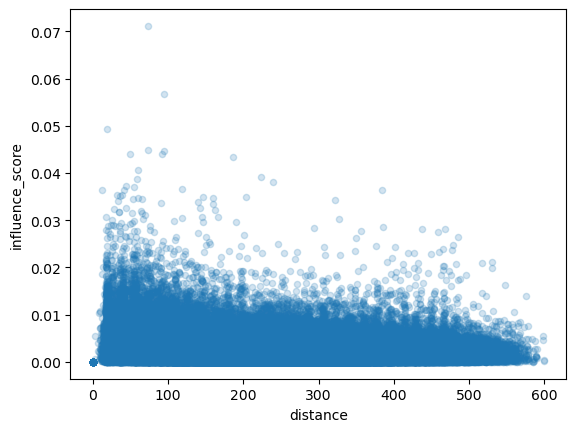

In [83]:
melted.plot.scatter('distance', 'influence_score', logy=False, alpha=0.2)

### Graph Based Distance Measure

In [84]:
edges = x['edges'].copy().astype(int)

coords = x['xpos'].copy()

edges = torch.Tensor(edges)
coords = torch.Tensor(coords)

data = tg.data.Data(edge_index=edges,
                    x=coords)

In [85]:
g = tg.utils.convert.to_networkx(data)

In [86]:
shortest_paths = nx.algorithms.shortest_paths.dense.floyd_warshall_numpy(g, weight=None)
shortest_paths = pd.DataFrame(shortest_paths)

shortest_paths_map = shortest_paths.melt(ignore_index=False)
shortest_paths_map = shortest_paths_map.reset_index()
shortest_paths_map = shortest_paths_map.rename(columns={'index': 'source',
                                                        'variable': 'target',
                                                        'value': 'graph_distance'}
                                               )

shortest_paths_map['graph_distance'] = shortest_paths_map['graph_distance'].astype('int')

<Axes: xlabel='graph_distance', ylabel='influence_score'>

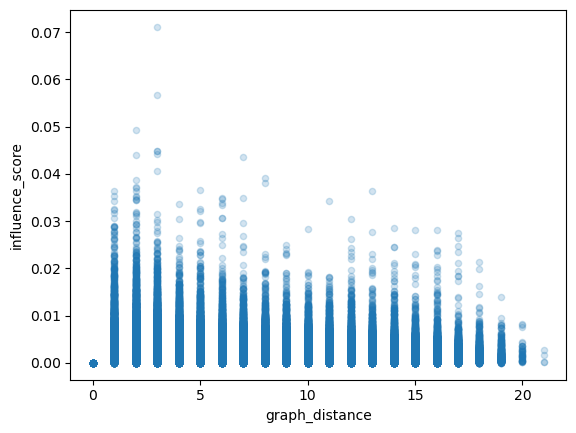

In [87]:
melted = melted.merge(shortest_paths_map, on=['source', 'target'])
melted.plot.scatter('graph_distance', 'influence_score', logy=False, alpha=0.2,)

,source,target,influence_score,source_x,source_y,target_x,target_y,distance_sq,distance,graph_distance
0,0,0,0.000000,9.00,9.000000,9.00,9.000,0.000000,0.000000,0
1,1,0,0.005699,9.00,27.500000,9.00,9.000,342.250000,18.500000,2
2,2,0,0.035197,9.00,45.500000,9.00,9.000,1332.250000,36.500000,2
3,3,0,0.008773,9.00,63.500000,9.00,9.000,2970.250000,54.500000,2
4,4,0,0.019835,9.00,81.500000,9.00,9.000,5256.250000,72.500000,3
...,...,...,...,...,...,...,...,...,...,...
238139,483,487,0.001374,365.75,475.500000,366.75,118.375,127539.265625,357.126404,10
238140,484,487,0.002925,365.25,491.500000,366.75,118.375,139224.515625,373.128021,10
238141,485,487,0.002083,365.75,9.101562,366.75,118.375,11941.684570,109.278015,3
238142,486,487,0.021824,365.75,100.812500,366.75,118.375,309.441406,17.590946,2


<Axes: xlabel='graph_distance'>

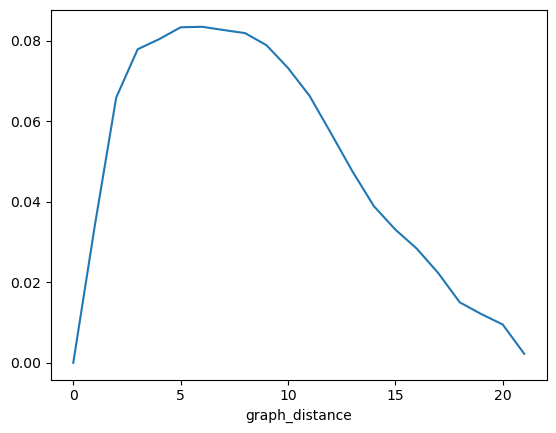

In [99]:
per_distance_per_source = melted.groupby(['graph_distance', 'source'])['influence_score'].sum()
per_distance_per_source.groupby('graph_distance').mean().plot()

In [102]:
per_distance_per_source.groupby('graph_distance').mean().sum()

1.0746539

### Put all of the above into a function, and run it on multiple graphs

In [115]:
def convert_positions_to_df(positions_array, label):
    assert label in {'source', 'target'}

    coords = pd.DataFrame(positions_array)

    coords.index.name = label
    coords = coords.reset_index()
    coords = coords.rename(columns={0: f'{label}_x',
                                    1: f'{label}_y'}
                           )
    return coords


def convert_arrays_to_df(influence_matrix, positions):
    df = pd.DataFrame(influence_matrix)

    df.index.name = 'source'  # TODO is this right?

    melted = df.melt(ignore_index=False)
    melted = melted.reset_index()  # Move source index to be a column, gives unique index
    melted = melted.rename(columns={'variable': 'target',
                                    'value': 'influence_score',
                                    'index': 'source'})

    source_coords = convert_positions_to_df(positions, label='source')
    target_coords = convert_positions_to_df(positions, label='target')

    melted = melted.merge(source_coords, on='source', how='left')
    melted = melted.merge(target_coords, on='target', how='left')

    return melted

def calculate_distance(influence_df):
    influence_df['distance_sq'] = (influence_df['source_x'] - influence_df['target_x'])**2 + (influence_df['source_y'] -
                                                                        influence_df['target_y'] )**2
    influence_df['distance'] = np.sqrt(influence_df['distance_sq'])

    return influence_df


def get_graph(edge_array, position_array):

    edges = edge_array.astype(int)

    edges = torch.Tensor(edges)
    position_array = torch.Tensor(position_array)

    data = tg.data.Data(edge_index=edges,
                        x=position_array)

    graph = tg.utils.convert.to_networkx(data)

    return graph


def add_graph_distances_to_df(influence_df, graph):
    shortest_paths = nx.algorithms.shortest_paths.dense.floyd_warshall_numpy(graph, weight=None)
    shortest_paths = pd.DataFrame(shortest_paths)

    shortest_paths_map = shortest_paths.melt(ignore_index=False)
    shortest_paths_map = shortest_paths_map.reset_index()
    shortest_paths_map = shortest_paths_map.rename(columns={'index': 'source',
                                                            'variable': 'target',
                                                            'value': 'graph_distance'}
                                                   )

    shortest_paths_map['graph_distance'] = shortest_paths_map['graph_distance'].astype('int')

    influence_df = influence_df.merge(shortest_paths_map, on=['source', 'target'])

    return influence_df

def raw_data_to_df(influence_matrix, position_array, edge_array, normalise):

    if normalise:
        print('Normalising influence matrix')
        influence_matrix = row_normalise(influence_matrix)

    influence_df = convert_arrays_to_df(influence_matrix, position_array)
    influence_df = calculate_distance(influence_df)
    graph = get_graph(edge_array, position_array)

    influence_df = add_graph_distances_to_df(influence_df, graph)

    return  influence_df


def process_all_graphs(pickle_file, normalise=False):
    with open(pickle_file, 'rb') as f:
        all_graphs = pickle.load(f)
        print(f"{len(all_graphs)} graphs loaded")

    dfs = []
    for i,graph in enumerate(all_graphs):
        influence_df = raw_data_to_df(graph['influence_score'],
                                      graph['xpos'],
                                      graph['edges'],
                                      normalise=normalise)
        influence_df['graph_id'] = i
        dfs.append(influence_df)

    final_df = pd.concat(dfs)
    final_df = final_df.sort_values(by='influence_score')
    final_df = final_df.reset_index(drop=True)

    return final_df




In [116]:
influence_df_gcn = process_all_graphs('inf_scores_gcn.pkl', normalise=True)

64 graphs loaded
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matr

In [117]:
influence_df_transformer = process_all_graphs('inf_scores_GT.pkl', normalise=True)

64 graphs loaded
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matr

In [ ]:
influence_df_egnn = process_all_graphs('inf_scores_egnn.pkl', normalise=True)

64 graphs loaded
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matrix
Normalising influence matr

In [ ]:
# fig, ax = plt.subplots()
# influence_df_gcn.plot.scatter('distance',
#                                   'influence_score',
#                                   logy=True,
#                                   ax=ax,
#                                   color='b')
#
# influence_df_transformer.plot.scatter('distance',
#                                 'influence_score',
#                                 logy=True,
#                                 ax=ax,
#                                 color='orange')

In [108]:
# fig, ax = plt.subplots()
# influence_df_gcn.plot.scatter('graph_distance',
#                                   'influence_score',
#                                   logy=True,
#                                   ax=ax,
#                                   color='b')
#
#
# # influence_df_egnn.plot.scatter('graph_distance',
# #                                 'influence_score',
# #                                 logy=True,
# #                                 ax=ax,
# #                                 color='orange')

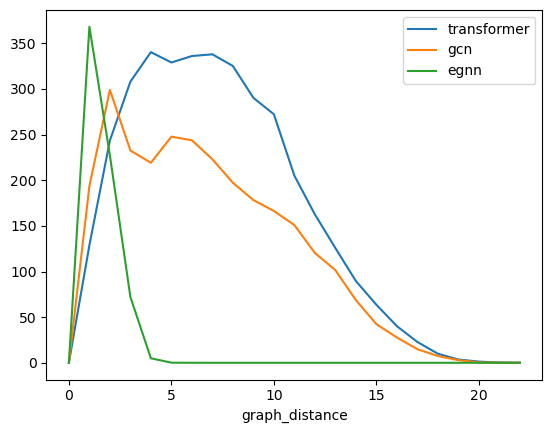

In [112]:
fig, ax = plt.subplots()
per_distance_per_source_trans = influence_df_transformer.groupby(['graph_distance', 'source'])['influence_score'].sum()
per_distance_per_source_trans.groupby('graph_distance').mean().plot(ax = ax, label='transformer')

per_distance_per_source_gcn = influence_df_gcn.groupby(['graph_distance', 'source'])['influence_score'].sum()
per_distance_per_source_gcn.groupby('graph_distance').mean().plot(ax=ax, label='gcn')

per_distance_per_source_egnn = influence_df_egnn.groupby(['graph_distance', 'source'])['influence_score'].sum()
per_distance_per_source_egnn.groupby('graph_distance').mean().plot(ax=ax, label='egnn')

ax.legend()